# Query Transformation

In [ ]:
from openai import OpenAI
import pandas as pd
import time 

# Set DeepSeek API key securely
client = OpenAI(api_key=API_KEY, base_url="https://api.deepseek.com")

PROMPT_TEMPLATE = '''
Your task is to analyze a given question and provide refined outputs by following the structured chain of thought below.  

Instructions:  
1. Generate Three Answers: Think of three possible answers to the given question `{Question}`.  
2. Identify Missing Element: Determine whether the question is missing a subject or an object.  
3. Rewrite Answers: For the three answers, rewrite them by removing the missing element and eliminating unnecessary stopwords (e.g., "an," "the," etc.).  
4. Output in Phrase Form: Provide the final output as concise phrases only.  

**Example**  
**Given Question:** *"Who is researching Renewable Energy technologies?"*  
- **Possible Answers:**  
   1. "Dr. B leads innovations in the Renewable Energy technologies."  
   2. "Dr. B develops renewable energy solutions."  
   3. "Dr. B is exploring advancements in renewables."  

- **Missing Element:** *Subject*  

- **Rewritten Answers:**  
   1. "lead innovations in Renewable Energyy technologies"  
   2. "develope renewable energy solutions"  
   3. "exploring advancements in renewables"  

**Final Output:**  
- lead innovations in Renewable Energy technologies  
- developing renewable energy solutions  
- exploring advancements in renewables  

Requirements:  
- Display **only the final three phrases** as output.  
- Do not include explanations, intermediate steps, or any additional information.  
'''  

# Function to get answers from DeepSeek using the latest API structure
def get_deepseek_response(prompt):
    prompt = PROMPT_TEMPLATE.format(Question=question)  # Fill the placeholder with the actual question
    retries = 3
    for i in range(retries):
        try:
            response = client.chat.completions.create(
                model="deepseek-chat",              # Use the DeepSeek chat model
                messages=[{"role": "user", "content": prompt}],
                max_tokens=300
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"API error: {e}. Retrying {i+1}/{retries}...")
            time.sleep(2 ** i)
    return None   

# Define file paths
input_filename = "../data/MSE-KG/KG_QA/Competency_Question.xlsx"  # Input file path
output_filename = "../data/MSE-KG/BM25/Competency_Question_3AQ.xlsx"  # Output file path

# Read the Excel file
question_df = pd.read_excel(input_filename)

# Strip any leading/trailing spaces from the column names
question_df.columns = question_df.columns.str.strip()

# Print the columns to verify
print("Columns in the file:", question_df.columns)

# Iterate over each question and apply the DP response function
auxiliary_queries = []  # Changed from simplified_phrases to auxiliary_queries
print("Processing questions... This may take some time.")
for question in question_df['Competency Question']:
    auxiliary_query = get_deepseek_response(question)  # Changed from simplified_phrase to auxiliary_query
    auxiliary_queries.append(auxiliary_query)

# Add the DP responses to the dataframe
question_df['Auxiliary Queries'] = auxiliary_queries  # Changed from Simplified Phrases to Auxiliary Queries

# Save the results to a new Excel file
question_df.to_excel(output_filename, index=False)
print(f"Processed data saved to: {output_filename}")

# BM25 Retrieval

In [ ]:
import pandas as pd
from langchain.retrievers import BM25Retriever
from langchain.schema import Document

class BM25:
    def __init__(self, documents):
        self.documents = [Document(page_content=line, metadata={"id": idx}) for idx, line in enumerate(documents) if len(line.strip()) > 5]
        self.retriever = BM25Retriever.from_documents(self.documents)

    def GetBM25TopK(self, query, topk):
        self.retriever.k = topk  # Dynamically set the k value
        ans_docs = self.retriever.get_relevant_documents(query)
        return ans_docs[:topk]

# File path configuration
TEXT_FILE_PATH = "../data/MSE-KG/KGPreprocess/verbalized_triples.txt"
EXCEL_FILE_PATH = "../data/MSE-KG/BM25/Competency_Question_3AQ.xlsx"

# Load text data
with open(TEXT_FILE_PATH, "r", encoding="utf-8") as file:
    document_lines = file.readlines()
document_lines = [line.strip() for line in document_lines if len(line.strip()) > 5]

# Initialize BM25 model
bm25_model = BM25(document_lines)

# Define function to merge and deduplicate
def merge_and_deduplicate(row):
    docs_q = set(row['BM25_TopK_Results_Ques'].split(' | ')) if row['BM25_TopK_Results_Ques'] else set()
    docs_p = set(row['BM25_TopK_Results_Aux'].split(' | ')) if row['BM25_TopK_Results_Aux'] else set()
    return ' | '.join(sorted(docs_q.union(docs_p)))

# Process different top-k values
for topk in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    # Reload the original data each time
    df = pd.read_excel(EXCEL_FILE_PATH)
    
    # Process main query column
    df['BM25_TopK_Results_Ques'] = [
        " | ".join([doc.page_content for doc in bm25_model.GetBM25TopK(query, topk)])
        for query in df.iloc[:, 0]
    ]
    
    # Process auxiliary query column
    aux_results = []
    for query in df['Auxiliary Queries']:
        elements = [elem.strip() for elem in query.split("\n") if elem.strip()]
        if len(elements) < 3:
            aux_results.append("")
            continue
        
        a, b, c = elements[:3]
        combined = set()
        for q_part in [a, b, c]:
            combined.update([doc.page_content for doc in bm25_model.GetBM25TopK(q_part, topk)])
        aux_results.append(" | ".join(sorted(combined)))
    
    df['BM25_TopK_Results_Aux'] = aux_results
    
    # Merge results
    df['Contexts'] = df.apply(merge_and_deduplicate, axis=1)
    
    # Save the file
    output_path = f"../data/MSE-KG/BM25/Contexts_by_BM25_3AQ_top{topk}.xlsx"
    df.to_excel(output_path, index=False)
    print(f"Generated top-{topk} result file: {output_path}")


# Generation

In [ ]:
# Generation Prompt Update
GENRATION_PROMPT_TEMPLATE = '''
Given the following question and combined factual contexts from two sources (triples and text):

Question: {question}
Context(s): {contexts}

Instructions:
1. Use Contexts Effectively: While the contexts provide information, they may contain redundancy. Focus on the most relevant triples that directly answer the question.
2. Leverage Understanding: Utilize your ability to comprehend and deduce the most essential details, even if some triples are less relevant or repetitive.
3. Direct Answers: Provide answers in a list format of phrases if appropriate, without any introductory phrases or complete sentences. Only provide the key facts.
4. Avoid Irrelevant Details: Omit information that does not directly contribute to answering the question.
5. List Format: When listing items, separate them with semicolons (;) instead of using dashes (-) or other symbols.
6. No Prefixes: Do not include any introductory phrases like "Based on the provided contexts" or "Answer:".
7. No Answer Indication: If no relevant information is found, simply return "(No Answer)" without any additional explanation.

Examples:
Question: Who was the first president of the United States?
Contexts:
George Washington was the first president of the United States.
George Washington took office in 1789.
George Washington won both presidential elections.

Answer:
George Washington
'''

In [ ]:
from openai import OpenAI
import pandas as pd
import time
import logging
import os
from tqdm import tqdm

# Configuration Constants
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1000
RETRY_COUNT = 3
SLEEP_INTERVAL = 1  # Rate limiting between API calls
DATA_DIR = "../data/MSE-KG/BM25/"
LOG_PATH = '../log/test.log'

# Set up logging
logging.basicConfig(
    filename=LOG_PATH,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def generate_answer(question: str, context: str) -> str:
    """Generates answer using OpenAI API with retry mechanism."""
    if not context.strip():
        return "[No relevant context found]"

    prompt = GENRATION_PROMPT_TEMPLATE.format(question=question, contexts=context)
    
    for attempt in range(RETRY_COUNT):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=MAX_TOKENS
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            logging.warning(f"API error (Attempt {attempt+1}/{RETRY_COUNT}): {str(e)}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return "[API Error: Maximum retries exceeded]"

def process_questions(df: pd.DataFrame) -> tuple[list, list]:
    """Processes dataframe rows and generates answers."""
    answers = []
    failed_indices = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Answers"):
        try:
            question = str(row.get('Competency Question', ''))
            context = str(row.get('Contexts', ''))
            answer = generate_answer(question, context)
            answers.append(answer)

            if index % 10 == 0:
                logging.info(f"Processed {index+1}/{len(df)}")

            time.sleep(SLEEP_INTERVAL)  # Global rate limiting
        except Exception as e:
            logging.error(f"Row {index} failed: {str(e)}")
            answers.append("[Error]")
            failed_indices.append(index)

    return answers, failed_indices

def process_single_file(input_path,output_path):

    try:
        df = pd.read_excel(input_path)
        
        # Validate and rename columns
        required_columns = ['Competency Question', 'Ground Truth', 'Contexts']
        if not all(col in df.columns for col in required_columns):
            df.columns = required_columns[:len(df.columns)]

        logging.info(f"Processing: {input_path}")
        answers, failed = process_questions(df)

        df['Answer'] = answers
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_excel(output_path, index=False)
        
        logging.info(f"Saved answers to {output_path}")
        print(f"[✓] Saved: {output_path}")
        if failed:
            logging.warning(f"Failed rows in {input_path}: {len(failed)}")
            print(f"[-] {len(failed)} rows failed in {input_path}")

    except Exception as e:
        logging.error(f"Error processing {input_path}: {str(e)}")
        print(f"[X] Error with file {input_path}: {str(e)}")

if __name__ == "__main__":
    for i in range(10, 101, 10):
        input_path = f"{DATA_DIR}Contexts_by_BM25_3AQ_top{i}.xlsx"
        output_path = f"{DATA_DIR}Predicted_Answers_Contexts_by_BM25_3AQ_top{i}_sentence_level.xlsx"
        process_single_file(input_path, output_path)
    process_single_file(input_path, output_path)


# Evaluation

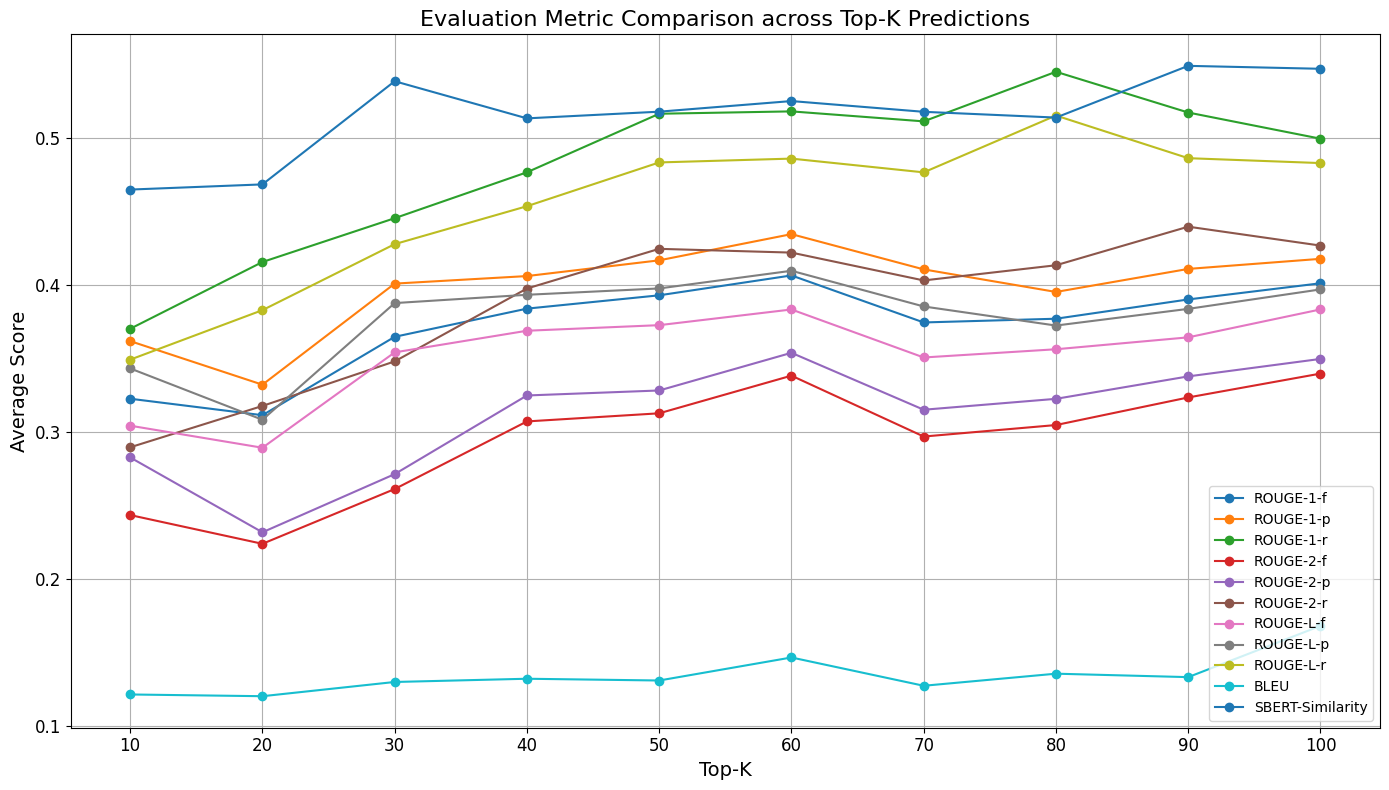

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/BM25/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:

    file_name = f"Predicted_Answers_Contexts_by_BM25_3AQ_top{top_k}_sentence_level.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_Contexts_by_BM25_3AQ_top{top_k}_sentence_level.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/BM25/Evaluation_Comparison_Averages_BM25_3AQ_Sentence_Level.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/BM25/Evaluation_Comparison_Averages_BM25_3AQ_Sentence_Level.png")
plt.show()